In [24]:
import networkx as nx
import json
import itertools
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

In [26]:
with open("friends.json", "r") as f:
    data = json.load(f)

In [27]:
adj_list = {int(k): v for k, v in data.items()}

In [28]:
g = nx.Graph(adj_list)

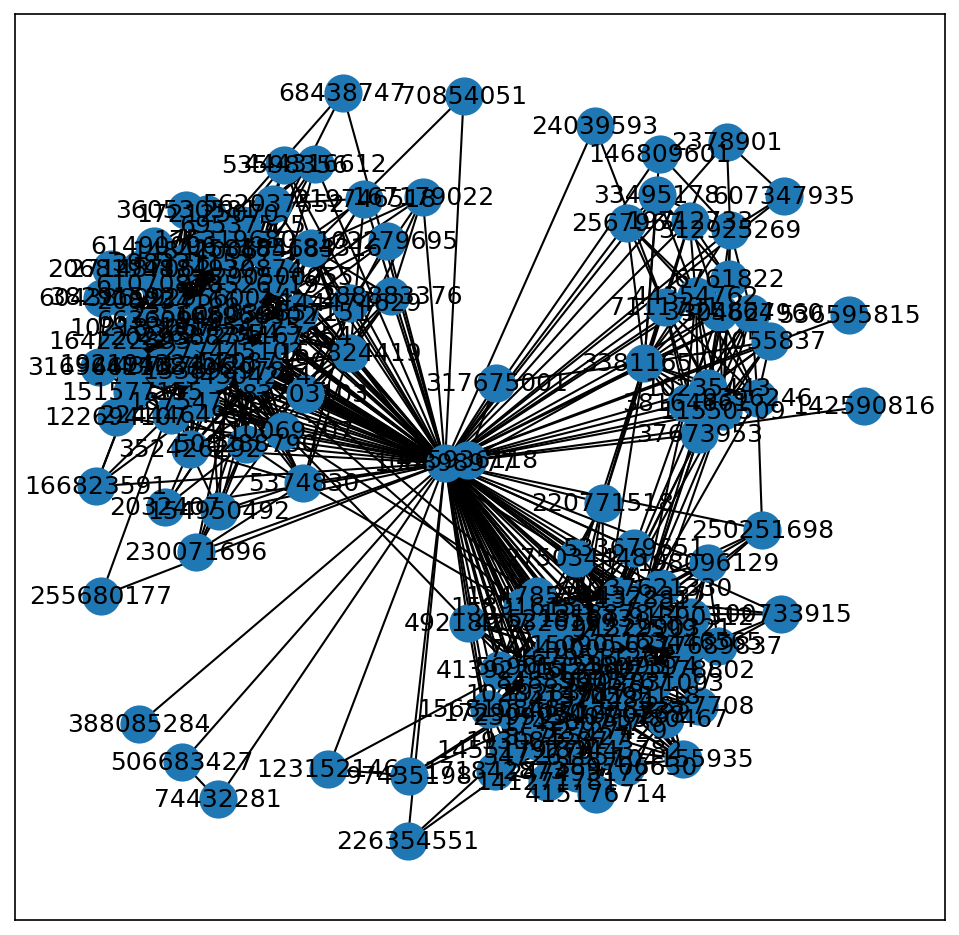

In [32]:
figure(figsize=(8,8), dpi=150)
nx.draw_networkx(g)
plt.show()